# **Entornos en AML**

Como científico de datos, quiere escribir código que funcione en cualquier entorno de desarrollo. Tanto si usa proceso local como en la nube, el código debe ejecutarse correctamente para entrenar un modelo de aprendizaje automático, por ejemplo.

Para ejecutar código, debe asegurarse de que los paquetes, las bibliotecas y las dependencias necesarios se instalan en el proceso que se usa para ejecutar el código. En Azure Machine Learning, los entornos de listan y almacenan los paquetes necesarios que puede reutilizar en los destinos de cómputo.

## **¿Qué es un entorno en Azure Machine Learning?**

El código de Python se ejecuta en el contexto de un entorno virtual que define la versión del tiempo de ejecución de Python que se va a usar, así como los paquetes instalados disponibles para el código. En la mayoría de las instalaciones de Python, los paquetes se instalan y administran en entornos con conda o pip.

Para mejorar la portabilidad, normalmente se crean entornos en contenedores de Docker que, a su vez, se hospedan en destinos de proceso, como el equipo de desarrollo, máquinas virtuales o clústeres en la nube.

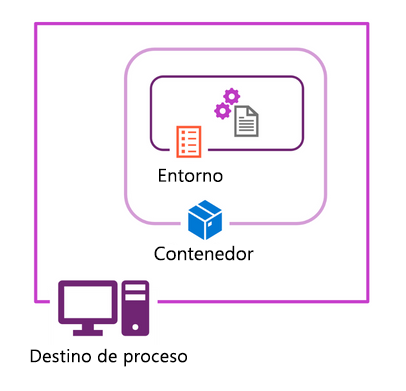


Para ver todos los entornos disponibles en el área de trabajo de Azure Machine Learning, puede enumerar los entornos en Estudio, mediante la CLI de Azure o con el SDK de Python.

In [ ]:
# para enumerar los entornos usando el SDK de Python:

envs = ml_client.environments.list()
for env in envs:
    print(env.name)

# para revisar los detalles de un entorno específico, puede recuperar el entorno por su nombre registrado:

env = ml_client.environments.get(name="my-environment", version="1")
print(env)

## **Explorar y usar entornos seleccionados**

- Entornos seleccionados son entornos precompilados para las cargas de trabajo de aprendizaje automático más comunes, disponibles en tu área de trabajo de forma predeterminada.

- Los entornos mantenidos usan el prefijo AzureML- y están diseñados para admitir scripts que utilizan marcos y utilidades populares de aprendizaje automático.

- Por ejemplo, hay entornos mantenidos para cuando desea ejecutar un script que entrena un modelo de regresión, agrupación en clústeres o clasificación con Scikit-Learn.

Para explorar un entorno curado, puede verlo en el estudio, mediante la CLI de Azure o el SDK de Python.

In [ ]:
env = ml_client.environments.get("AzureML-sklearn-0.24-ubuntu18.04-py37-cpu", version=44)
print(env. description, env.tags)

### Usar un entorno curado
Normalmente, se usan entornos cuando se quiere ejecutar un script como (comando) job.

- Para especificar qué entorno se desea usar para ejecutar el script, se hace  referencia a un entorno por su nombre y versión.

Por ejemplo, el código siguiente muestra cómo configurar un trabajo de comando con el SDK de Python, que usa un entorno gestionado, incluido Scikit-Learn:

In [ ]:
from azure.ai.ml import command

# configure job
job = command(
    code="./src",
    command="python train.py",
    environment="AzureML-sklearn-0.24-ubuntu18.04-py37-cpu@latest",
    compute="aml-cluster",
    display_name="train-with-curated-environment",
    experiment_name="train-with-curated-environment"
)

# submit job
returned_job = ml_client.create_or_update(job)

## **Probar y resolver problemas de un entorno curado**
Como los entornos gestionados permiten un tiempo de implementación más rápido, es una práctica recomendada explorar primero si uno de los entornos gestionados creados previamente se puede usar para ejecutar el código.
- Se Puede comprobar que un entorno mantenido incluye todos los paquetes necesarios revisando sus detalles. 
- Luego se puede probar el entorno ejecutando el script.

Si un entorno no incluye todos los paquetes necesarios para ejecutar el código, se produce un error en el trabajo.

- Se puede revisar los logs de error detallados en la pestaña Salidas + logs de job en Azure Machine Learning Studio.

- Un mensaje de error común que indica que el entorno está incompleto, es `ModuleNotFoundError`.
    - El módulo que no se encuentra aparece en el mensaje de error. 
    - Al revisar el mensaje de error, se puede actualizar el entorno para incluir las librerías para asegurarse de que los paquetes necesarios están instalados en el destino de proceso antes de ejecutar el código.

Cuando se necesite especificar otros paquetes necesarios, se puede usar un entorno gestionado como referencia para sus propios entornos personalizados modificando los Dockerfiles.

## **Creación y uso de entornos personalizados**

Cuando se necesite crear un entorno en Azure Machine Learning para enumerar todos los paquetes, liberías y dependencias necesarios para ejecutar los scripts.

Se Puede definir un entorno a partir de una imagen de Docker, un contexto de compilación de Docker y una especificación de Conda con la imagen de Docker.

### Creación de un entorno personalizado a partir de una imagen de Docker

Las imágenes de Docker se pueden hospedar en un registro público, como [Docker Hub](https://hub.docker.com/) o almacenarse de forma privada en una instancia de Azure Container Registry.

In [ ]:
from azure.ai.ml.entities import Environment

env_docker_image = Environment(
    image="pytorch/pytorch:latest",
    name="public-docker-image-example",
    description="Environment created from a public Docker image.",
)
ml_client.environments.create_or_update(env_docker_image)

También puede usar las imágenes base de Azure Machine Learning para crear un entorno (que es similar a las imágenes usadas por entornos mantenidos):

In [ ]:
from azure.ai.ml.entities import Environment

env_docker_image = Environment(
    image="mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04",
    name="aml-docker-image-example",
    description="Environment created from a Azure ML Docker image.",
)
ml_client.environments.create_or_update(env_docker_image)

### Creación de un entorno personalizado con un archivo de especificación de Conda

Cuando necesite incluir otros paquetes o bibliotecas en su entorno, puede agregar un archivo de especificación de Conda a una imagen de Docker al crear el entorno.

Un archivo de especificación de Conda es un archivo YAML, que enumera los paquetes que deben instalarse mediante conda o pip. Este tipo de archivo YAML puede tener el siguiente aspecto:

```yaml
name: basic-env-cpu
channels:
  - conda-forge
dependencies:
  - python=3.7
  - scikit-learn
  - pandas
  - numpy
  - matplotlib
```


Para crear un entorno a partir de una imagen base de Docker y un archivo de especificación de Conda, puede usar el código siguiente:

In [ ]:
from azure.ai.ml.entities import Environment

env_docker_conda = Environment(
    image="mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04",
    conda_file="./conda-env.yml",
    name="docker-image-plus-conda-example",
    description="Environment created from a Docker image plus Conda environment.",
)
ml_client.environments.create_or_update(env_docker_conda)

### **Uso de un entorno**

Normalmente, se usan entornos cuando deseas ejecutar un script como (comando) job.

In [ ]:
from azure.ai.ml import command

# configure job
job = command(
    code="./src",
    command="python train.py",
    environment="docker-image-plus-conda-example:1",
    compute="aml-cluster",
    display_name="train-custom-env",
    experiment_name="train-custom-env"
)

# submit job
returned_job = ml_client.create_or_update(job)